In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from musicautobot.imports import *
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.vocab import *

# Do this instead
from musicautobot.music_transformer.all import *
from musicautobot.multitask_transformer.all import *

In [3]:
from fastai.text.all import *

In [4]:
torch.cuda.set_device(2)

## MultitaskTransformer Training

**NOTE** 
This notebook assumes you've already preprocessed `reddit_musicitem_data_save.pkl`.  
If you haven't, run `musicautobot/notebook/music_transformer/DataPreprocessing-Reddit.ipynb` first.

## End to end training pipeline 

1. Create and encode dataset
2. Initialize Transformer MOdel
3. Train
4. Predict

In [5]:
base_path = Path('../data/soundpack_midi')

# Location of your midi files
midi_path = base_path/'midi_sources/hooktheory'

# Location to save dataset
s2s_path = base_path/'s2s_encode/hooktheory'
lm_path = base_path/'piano_duet/hooktheory'

[p.mkdir(parents=True, exist_ok=True) for p in [midi_path, s2s_path, lm_path]];

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [6]:
min_variation = 3 # minimum number of different midi notes played

In [7]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

2057

In [8]:
def is_valid_part(p, min_pitch_var=3, min_notes=9):
    if isinstance(p.getInstrument(), music21.instrument.Percussion): return False
    pitches = p.pitches
    if len(set(pitches)) < min_pitch_var: return False
    if len(p.pitches) < min_notes: return False
    return True

In [9]:
def is_valid_npenc(npenc, min_notes=9, note_range=PIANO_RANGE, max_dur=DUR_SIZE):
    if len(npenc) < min_notes: return False
    
    if (npenc[:,1] >= max_dur).any(): return False
    # https://en.wikipedia.org/wiki/Scientific_pitch_notation - 88 key range - 21 = A0, 108 = C8
    if ((npenc[...,0] > VALTSEP) & ((npenc[...,0] < note_range[0]) | (npenc[...,0] >= note_range[1]))).any(): return False
    return True

## Playground

### TODO: 
### USE PIPELINE TO DO TRANSFORMATION
### USE fastai core @patch to make these functions part of music21 library

In [10]:
# input_path = midi_files[0]

# stream = file2stream(input_path)

# ## Should we filter out pitches outside of max keyboard notes here?

# pitches = stream.parts[0].pitches
# p = pitches[0]
# p.midi

# len(list(stream.parts[1].getElementsByClass('Chord')))

# ## Should we set max duration of notes here?

# notes = stream.parts[0].notes
# n = notes[0]
# n.beatDuration.quarterLength = 8

# stream.remove([p for p in stream.parts if not is_valid_part(p)])

## Transform MIDI

In [11]:
def stream2parts(stream):
    if not isinstance(stream, music21.stream.Score): stream = stream.voicesToParts()
    stream.quantize(inPlace=True)
    
    ## Should we filter out pitches outside of max keyboard notes here?
    ## Should we set max duration of notes here?
    
    invalid_parts = [p for p in stream.parts if not is_valid_part(p)]
    if invalid_parts: print(f'Found {len(invalid_parts)} invalid parts')
    stream.remove(invalid_parts)
    num_parts = len(stream.parts)
    if num_parts > 2: raise ValueError('Could not extract melody and chords. Midi file must contain exactly 2 tracks')
    elif num_parts == 1:
        stream = separate_melody_chord(stream)

    m, c = list(stream.parts)
    if len(list(m.getElementsByClass('Chord'))) > len(list(c.getElementsByClass('Chord'))):
        raise ValueError('Inverted melody track and chord track. Skipping...')
        
    return stream

In [12]:
def transform_midi(midi_file):
    
    # Part 1. Compress rests and long notes
    try:
        stream = file2stream(midi_file) # 1.
        stream = stream2melodychords(stream)
    except Exception as e: 
        return print('Could not parse stream:', midi_file, e)
    
    try: 
        chordarr = stream2chordarr(stream) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
        chordarr = trim_chordarr_rests(chordarr)
        chordarr = shorten_chordarr_rests(chordarr)
    except Exception as e: 
        return print('Could not encode to chordarr:', midi_file, e)
    
    # Individual parts must have notes
    parts = [part_enc(chordarr, i) for i in range(chordarr.shape[1])]
    parts = [p for p in parts if is_valid_npenc(p)]
    if len(parts) != 2: return print('Could not encode to npenc', midi_file)
    
    return parts

In [13]:
def process_metadata(midi_file):
    # Get outfile and check if it exists
    out_file = s2s_path/midi_file.relative_to(midi_path).with_suffix('.npy')
    out_file.parent.mkdir(parents=True, exist_ok=True)
    if out_file.exists(): return
    
    npenc = transform_midi(midi_file)
    if npenc is not None: np.save(out_file, np.array(npenc, dtype=object))

In [25]:
# # sanity check
import random
# for mf in random.sample(midi_files, 10):
for mf in midi_files:
    print(mf)
    process_metadata(mf)

../data/soundpack_midi/midi_sources/hooktheory/billboard/Jess Glynne - Hold My Hand - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Colbie Caillat - Brighter Than The Sun - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Shakira - La Tortura Ft Alejandro Sanz - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Walk The Moon - Shut Up And Dance - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lorde - Team - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Weeknd - The Hills - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Phoenix - 1901 - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Ciara - Oh - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Shins - Phantom Limb - verse_key_cmajor.mid
../data/soundpack_midi/midi_s

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Brandi Carlile - Closer To You - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem - Headlights   Ft Nate Ruess - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - Alright - pre-chorus_key_cmajor.mid
Found 1 invalid parts
Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - Alright - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Live While Were Young - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Clocks - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Meghan Trainor - Dear Future Husband - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Twenty One Pilots - Stressed Out - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Childish Gambino - Me And Your Mama - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Calvin Harris - I Need Your Love - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jewel - Intuition - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Modest Mouse - Float On - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Dnce - Toothbrush - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Lumineers - Ophelia - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Ace - Drifting Soul   Xenoblade Chronicles 2 - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Chainsmokers - Roses Ft Rozes - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem - Rip - instrumental_key_cmajor.mid
Inval

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Hell Of A Life - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Gaga - Born This Way - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kylie Minogue - Cant Get You Out Of My Head - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Timbaland Ft Katy Perry - If We Ever Meet Again - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jewel - Intuition - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - God - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Nelly Furtado - Turn Off The Light - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Radiohead - Nude - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Bon Jovi - Livin

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem Ft Rihanna - Love The Way You Lie - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Korn - Freak On A Leash - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Imagine Dragons - Radioactive - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Style - intro_key_cmajor.mid
Found 1 invalid parts
Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Style - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Macklemore And Ryan Lewis - Cant Hold Us - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Gotye - Somebody That I Used To Know - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Paradise - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylo

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Clocks - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Muse - Uprising - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Gaga - Just Dance - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - 22 - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Fifteen - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/George Michael - Careless Whispers - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Black Eyed Peas - Meet Me Halfway - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Veronicas - Untouched - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Queen - Somebody To Love - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/mi

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Waves - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/U2 - Stuck In A Moment You Cant Get Out Of - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Mika - Grace Kelly - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jennifer Lopez - Dance Again - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Foo Fighters - Rope - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Calvin Harris - Summer - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Fergie - Fergalicious - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Empire Of The Sun - Walking On A Dream - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/S Club 7 - Never Had A Dream

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Brad Paisley - Shes Everything - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Meghan Trainor - Like Im Gonna Lose You Feat John Legend - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Gwen Stefani - The Sweet Escape - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Enrique Iglesias - Escape - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Brandy - Almost Doesnt Count - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Chevelle - Send The Pain Below - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Demi Lovato - Body Say - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - State Of Grace - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - When Your

Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Switchfoot - Meant To Live - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Nelly Furtado - Say It Right - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem - The Real Slim Shady - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Keane - Somewhere Only We Know - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Queen - Bohemian Rhapsody - solo-2_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Sia - Chandelier - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/David Bowie - Space Oddity - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Walk The Moon - Shut Up And Dance - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Andy Grammer - Keep Your Head Up - pre-chorus_key_cmajor.

../data/soundpack_midi/midi_sources/hooktheory/billboard/Miley Cyrus - Wrecking Ball - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Leona Lewis - I Will Be - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Twenty One Pilots - Fairly Local - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Weeknd - Cant Feel My Face - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Beyonce - If I Were A Boy - outro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Aulii Cravalho - How Far Ill Go - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Daft Punk - Get Lucky - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - Sk8Er Boi - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Paramore - Hard Times - outro_key_cmajor.mid
.

../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Gaga - Judas - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Imagine Dragons - Its Time - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - When Youre Gone - chorus_key_cmajor.mid
Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - When Youre Gone - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Rock Me - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Michael Jackson - Bad - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Speed Of Sound - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Beyonce - If I Were A Boy - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Andy Grammer - Honey Im Good - chorus_key_cmajor.mid


Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Skrillex - Bangarang Feat Sirah - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Eyes Open - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Creed - Higher - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - King Kunta - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Vertical Horizon - Frost - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Daniel Powter - Bad Day - chorus-lead-out_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - Complicated - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Robin Schulz - Sugar Feat Francesco Yates - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Arcade Fire - Reflektor - bridge_key_cmajor.mid
Inva

../data/soundpack_midi/midi_sources/hooktheory/manual/The Chainsmokers - Don't Let Me Down - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Kygo - It Ain't Me - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Taylor Swift - Shake It Off - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Coldplay - Hymn For The Weekend - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/John O'Callaghan - Find Yourself - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Sum41 - Fat Lip - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/John Dahlback - Fireflies - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/One Republic - Counting Stars - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Pokemon - verse_key_cmajor.mid
../data/soundpack_midi/midi_so

In [17]:
def timeout_func(data, seconds):
    print("Timeout:", seconds, data.get('midi'))

In [18]:
processed = process_all(process_metadata, midi_files, timeout=120, timeout_func=timeout_func)

Found 1 invalid partsInvalid npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Power - intro_key_cmajor.mid
Invalid npencWarning: only 1 track found. Inferring melody/chords
 ../data/soundpack_midi/midi_sources/hooktheory/billboard/Gwen Stefani - The Sweet Escape - intro_key_cmajor.mid

Invalid npencInvalid npencWarning: only 1 track found. Inferring melody/chords  
../data/soundpack_midi/midi_sources/hooktheory/billboard/Michael Buble - Its A Beautiful Day - verse_key_cmajor.mid../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Ultralight Beam - chorus_key_cmajor.mid

Invalid npenc Found 1 invalid partsInvalid npenc../data/soundpack_midi/midi_sources/hooktheory/billboard/Brandi Carlile - Closer To You - verse_key_cmajor.mid

 ../data/soundpack_midi/midi_sources/hooktheory/billboard/Michael Buble - Its A Beautiful Day - pre-chorus_key_cmajor.mid



 Invalid npenc
Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Miley Cy

 ../data/soundpack_midi/midi_sources/hooktheory/billboard/Alex Clare - Too Close - intro_key_cmajor.mid../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem - Lose Yourself - verse-and-pre-chorus_key_cmajor.mid

Found 1 invalid parts
Invalid npencWarning: only 1 track found. Inferring melody/chords
 ../data/soundpack_midi/midi_sources/hooktheory/billboard/Switchfoot - Meant To Live - chorus_key_cmajor.mid
Invalid npenc Invalid npenc ../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - State Of Grace - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Mr Probz  - Waves Robin Schulz Remix - intro_key_cmajor.midWarning: only 1 track found. Inferring melody/chords

Invalid npenc Found 1 invalid parts../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Enchanted - intro_key_cmajor.mid

Invalid npencWarning: only 1 track found. Inferring melody/chordsWarning: only 1 track found. Inferring melody/chords
../data/s

ValueError: not enough values to unpack (expected 2, got 0)

### 2a. Create sequence to sequence dataset

In [15]:
def create_databunch(files, data_save_name, path=data_path):
    save_file = path/data_save_name
    if save_file.exists():
        data = load_data(path, data_save_name)
    else:
        save_file.parent.mkdir(exist_ok=True, parents=True)
        vocab = MusicVocab.create()
        processors = [S2SFileProcessor(), S2SPartsProcessor()]

        data = MusicDataBunch.from_files(files, path, processors=processors, 
                                          preloader_cls=S2SPreloader, list_cls=S2SItemList, dl_tfms=melody_chord_tfm)
        data.save(data_save_name)
    return data

In [16]:
s2s_numpy_files = get_files(s2s_numpy_path, extensions='.npy', recurse=True); len(s2s_numpy_files)

31

In [17]:
s2s_data = create_databunch(s2s_numpy_files, data_save_name=s2s_data_save_name); s2s_data

/home/ashaw/musicautobot/musicautobot/multitask_transformer/transform.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  def to_idx(self): return np.array((self.melody.to_idx(), self.chords.to_idx()))


MusicDataBunch;

Train: LabelList (28 items)
x: S2SItemList
<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f59177444f0>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f591773bc40>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f591773b160>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f59166f7400>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f59166f7160>
y: LMLabelList
,,,,
Path: ../../data/cached;

Valid: LabelList (3 items)
x: S2SItemList
<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f591773bf10>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f59177446d0>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f5917744220>
y: LMLabelList
,,
Path: ../../data/cached;

Test: None

Structure

In [18]:
xb, yb = s2s_data.one_batch(); xb

{'c2m': {'enc': tensor([[  5,   1,  59,  ..., 139,  55, 139],
          [  5,   1,  66,  ..., 140,  71, 140],
          [  5,   1,  61,  ...,   1,   1,   1],
          ...,
          [  5,   1,  69,  ..., 145,  69, 145],
          [  5,   1,   8,  ...,   1,   1,   1],
          [  5,   1,  61,  ..., 145,  66, 145]]),
  'enc_pos': tensor([[  0,   0,   0,  ...,  52,  52,  52],
          [  0,   0,   0,  ..., 112, 112, 112],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,  56,  64,  64],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ..., 112, 112, 112]]),
  'dec': tensor([[  6,   1,  83,  ..., 139,   8, 139],
          [  6,   1,  83,  ..., 139,   8, 139],
          [  6,   1,  66,  ..., 139,   8, 139],
          ...,
          [  6,   1,  66,  ..., 138,   8, 138],
          [  6,   1,   8,  ..., 139,  59, 139],
          [  6,   1,   8,  ..., 147,  93, 141]]),
  'dec_pos': tensor([[ 0,  0,  0,  ..., 76, 76, 76],


Key:
* 'c2m' = chord2melody translation
 * enc = chord
 * dec = melody
* 'm2c' = next word input
 * enc = melody
 * dec = chord
* 'pos' = timestepped postional encoding. Gives the model a better reference when translating

Note: MultitaskTransformer trains both translations ('m2c' and 'c2m') at the same time. 

### 2b. Create NextWord/Mask Dataset

Please run `Step 2` in `musicautobot/notebook/music_transformer/DataPreprocessing-Reddit.ipynb` to complete this step

In [21]:
batch_size = 2
bptt = 128
lm_data = load_data(data_path, lm_data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm_pitchdur)

In [22]:
xb, yb = lm_data.one_batch(); xb

{'msk': {'x': tensor([[145,   8, 141,   4, 139,   8, 139,   4, 139,   8, 139,   4, 139,  56,
           145,   4, 145,   4, 145,   8, 139,   4, 139,   8, 139,  86, 139,   8,
           139,   4, 139,   8, 139,   4, 139,  81, 141,  57, 141,   4, 141,   8,
           139,  91, 138,   8, 138,  89, 139,   8, 138,   4, 139,   4, 139,   4,
           139,   8, 138,  89, 138,   8, 138,   4, 138,   4, 147,   4, 147,  63,
           147,   8, 138,   4, 139,   8, 140,   4, 138,   8, 138,   4, 138,   8,
           138,   4, 139,   8, 139,   4, 138,   8, 138,  77, 138,   8, 138,   4,
           141,   4, 145,  60, 145,   4, 145,   8, 141,   4, 139,   8, 139,   4,
           141,   8, 139,  81, 145,   4, 145,  46, 145,   8, 139,   4, 139,   8,
           139,  91],
          [145,   8, 141,   4, 139,   8, 139,   4, 139,   8, 139,  89, 139,   4,
           145,   4, 145,   4, 145,   8, 139,   4, 139,   8, 139,   4, 139,   8,
           139,   4, 139,   8, 139,   4, 139,   4, 141,   4, 141,  53, 141,

Key:
* 'msk' = masked input
* 'lm' = next word input
* 'pos' = timestepped postional encoding. This is in addition to relative positional encoding

Note: MultitaskTransformer trains on both the masked input ('msk') and next word input ('lm') at the same time.

The encoder is trained on the 'msk' data, while the decoder is trained on 'lm' data.



## 3. Initialize Model

In [23]:
# Load Data
batch_size = 2
bptt = 128

lm_data = load_data(data_path, lm_data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm_pitchdur)

s2s_data = load_data(data_path, s2s_data_save_name, 
                     bs=batch_size//2, bptt=bptt,
                     preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

# Combine both dataloaders so we can train multiple tasks at the same time
data = StackedDataBunch([lm_data, s2s_data])

In [24]:
# Create Model
config = multitask_config(); config

learn = multitask_model_learner(data, config.copy())
# learn.to_fp16(dynamic=True) # Enable for mixed precision

In [25]:
learn.model

MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=512, out_features=512, bias=True)
        )
        (mha2): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=

# 4. Train

In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,7.308124,15.408500,0.032946,0.000000,0.251969,0.118671,00:13
1,7.361933,11.252718,0.038371,0.082811,0.251969,0.118671,00:13
2,7.051270,13.166666,0.145320,0.035301,0.251969,0.118671,00:13
3,6.805200,7.204962,0.193508,0.176227,0.251969,0.118671,00:13


In [ ]:
learn.save('example')

## Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [27]:
# midi_files = get_files(midi_path, '.mid', recurse=True)
midi_file = base_path/'midi/notebook_examples/single_bar_example.mid'; midi_file

PosixPath('../../data/midi/notebook_examples/single_bar_example.mid')

/home/ashaw/musicautobot/musicautobot/multitask_transformer/learner.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_choices = len(probs.nonzero().view(-1))


Non midi note detected. Only returning valid portion. Index, seed 22 (27, 2)


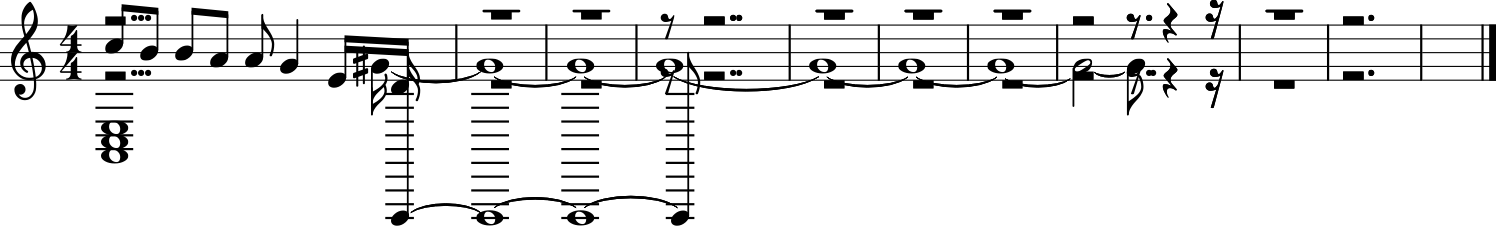

In [28]:
next_word = nw_predict_from_midi(learn, midi_file, n_words=20, seed_len=8); next_word.show()

Non midi note detected. Only returning valid portion. Index, seed 15 (25, 2)


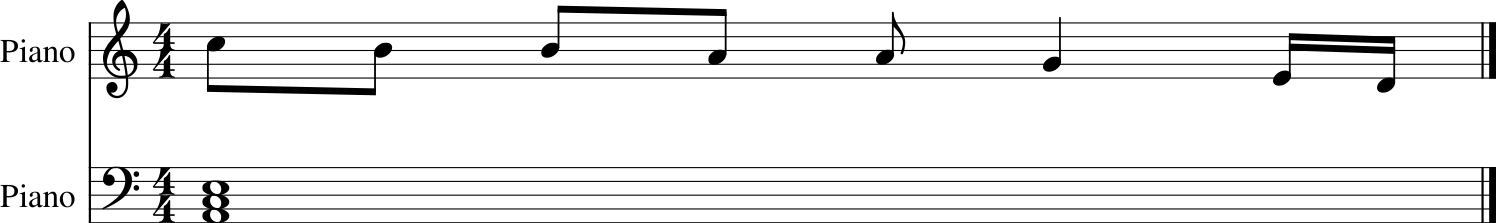

In [31]:
pred_melody = s2s_predict_from_midi(learn, midi_file, n_words=20, seed_len=4, pred_melody=True); pred_melody.show()

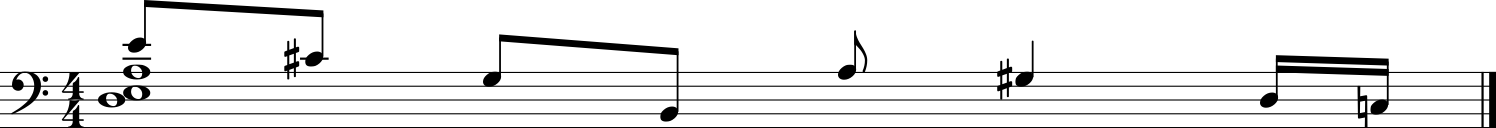

In [30]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()